# 1-hour Geospatial Data Processing Cookbook

Sibo Wang (sibowsb ᎪᎢ gmail ᎠОᎢ com)  
May 13, 2019

## What is this?
This is a quick start guide for working with geospatial data. I wrote part of this tutorial myself, and used contents from open source guides and tutorials elsewhere for some other parts (see sources and licenses in individual sections).

This document works the best for those with some background in computer science but no experience in handling geospatial data. For those readers, it's my intension that following this tutorial should take roughly 1 hour. I assume the readers are fluent in Python, are familiar with NumPy, Pandas, and Matplotlib, and are able to navigate through a UNIX system through Bash.

The materials included in this document, as well as the structure of it, are largely based on my personal experience and my works at NRES/NCSA/CS at UIUC. They might not suit everybody's needs.

## Software/libraries used in this tutorial

- [Python](https://www.python.org/)
- [NumPy](https://www.numpy.org/)
- [RasterIO](https://github.com/mapbox/rasterio)
- [GeoPandas](http://geopandas.org/)
- [Matplotlib](https://matplotlib.org/)
- [QGIS](https://www.qgis.org) (This is a desktop program for visualization purposes)

If you install the above-mentioned libraries using a package manager (eg. Conda), the following libraries should have been installed as prerequisites as well:
- [Pandas](https://pandas.pydata.org/)
- [Shapely](https://github.com/Toblerity/Shapely)
- [PyProj](https://github.com/pyproj4/pyproj)
- [affine](https://github.com/sgillies/affine)
- [OSGeo](https://www.osgeo.org/) (a family of packages including GDAL, OGR, etc.)

The versions of my installation of these libraries are:

In [1]:
!python -V

Python 3.7.2


In [1]:
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import pyproj
import affine
import osgeo

for module in [np, rasterio, gpd, matplotlib, pd, shapely, pyproj, affine, osgeo]:
    print('%s: %s' % (module.__name__, module.__version__))

numpy: 1.15.4
rasterio: 1.0.13
geopandas: 0.4.0
matplotlib: 3.0.2
pandas: 0.24.1
shapely: 1.6.4.post1
pyproj: 1.9.6
affine: 2.2.2
osgeo: 2.3.3


I'm using QGIS 3.4.4-Madeira for Mac.

If you are using different versions, you may find incompatibilities, in which case you may need to Google the solution yourself. 

## Types of geospatial data (raster vs vector)

There is a [very good explaination](https://gis.stackexchange.com/a/57170) of this topic on GIS StackExchange by `JamesS` (license: [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/)):

> In GIS, vector and raster are two different ways of representing spatial data. However, the distinction between vector and raster data types is not unique to GIS: [here](https://helpx.adobe.com/photoshop-elements/key-concepts/raster-vector.html) is an example from the graphic design world which might be clearer.
>
> Raster data is made up of pixels (or cells), and each pixel has an associated value. Simplifying slightly, a digital photograph is an example of a raster dataset where each pixel value corresponds to a particular colour. In GIS, the pixel values may represent elevation above sea level, or chemical concentrations, or rainfall etc. The key point is that all of this data is represented as a grid of (usually square) cells. The difference between a digital elevation model (DEM) in GIS and a digital photograph is that the DEM includes additional information describing where the edges of the image are located in the real world, together with how big each cell is on the ground. This means that your GIS can position your raster images (DEM, hillshade, slope map etc.) correctly relative to one another, and this allows you to build up your map.
>
> Vector data consists of individual points, which (for 2D data) are stored as pairs of (x, y) co-ordinates. The points may be joined in a particular order to create lines, or joined into closed rings to create polygons, but all vector data fundamentally consists of lists of co-ordinates that define vertices, together with rules to determine whether and how those vertices are joined.
>
> Note that whereas raster data consists of an array of regularly spaced cells, the points in a vector dataset need not be regularly spaced.
>
> In many cases, both vector and raster representations of the same data are possible:
> ![](https://i.stack.imgur.com/mO0tU.png)
> At this scale, there is very little difference between the vector representation and the "fine" (small pixel size) raster representation. However, if you zoomed in closely, you'd see the polygon edges of the fine raster would start to become pixelated, whereas the vector representation would remain crisp. In the "coarse" raster the pixelation is already clearly visible, even at this scale.  
>
> Vector and raster datasets have different strengths and weaknesses, some of which are described in the thread linked to by @wetland. When performing GIS analysis, it's important to think about the most appropriate data format for your needs. In particular, careful use of raster algebra can often produce results much, much faster than the equivalent vector workflow.

In the end, the format of data largely depends on the nature of your content. For example, if you want to specify the geometry of some farms or mark the location of some ground sensors, using a vector dataset is a good idea. If you want to present some property of the entire landscape (for example, if you want to display the broadband albedo or some vegetation index of a county), you probably want to use a raster map. However, if you want to present the same albedo or VI data for each farm, you may want to go back to a vector dataset with the attributes attached to each polygon geometry.

The most popular format for georeferenced raster image is GeoTiff (`.tif` or `.tiff`). Other formats include JPEG2000 (`.jp2`, used by Sentinel 2), Band Interleaved by Line (`.bil`, used by PRISM climate data), etc. The most popular format for georeferenced vector data is ESRI Shapefile (`.shp` accompanied by several other files with different extensions). I think Shapefile is outdated and shouldn't be used anymore (see [arguments here](http://switchfromshapefile.org/)). As an alternative I've been using GeoPackage (`.gpkg`) for a while and it's been quite satisfactory so far in terms of reading/writing speed, convinience of use, and compatibility with common existing programs. Other common vector file formats include GeoJSON (`.json` or `.geojson`), SpatiaLite, etc.

### Typical data sources

The followings are some typical vector/raster open-access datasets. Disclaimer: I haven't used all these data myself—I only selected them for demo purposes.

#### Vector datasets
- [US county boundaries](https://catalog.data.gov/dataset/tiger-line-shapefile-2017-nation-u-s-current-county-and-equivalent-national-shapefile)
- [Global river network map](http://gaia.geosci.unc.edu/rivers/)

#### Raster datasets
- [Cropland Data Layer (CDL)](https://nassgeodata.gmu.edu/CropScape/): this gives the land cover type of each 30m-by-30m grid of CONUS.
- [US Census Grids](https://sedac.ciesin.columbia.edu/data/collection/usgrid): this gives data such as total population of each grid of the US.
- [ASTER Global Digital Elevation Model (GDEM)](https://asterweb.jpl.nasa.gov/gdem.asp): this gives the altitude of each grid of the earth.

## Georeferencing

### Projection / Coordinate Reference System (CRS)

Drawing a 3D earth on a 2D surface without some sort of distortion is impossible. Therefore, we use map projections, aka. Coordinate Reference Systems (CRS), to translate positions on a 3D sphere to a 2D map. From [Wikipedia](https://en.wikipedia.org/wiki/Map_projection):
> A map projection is a systematic transformation of the latitudes and longitudes of locations from the surface of a sphere or an ellipsoid into locations on a plane ... Depending on the purpose of the map, some distortions are acceptable and others are not; therefore, different map projections exist in order to preserve some properties of the sphere-like body at the expense of other properties. There is no limit to the number of possible map projections.

[This site](https://map-projections.net/singleview.php) visualizes some map projections systems (license: [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)). A screenshot of the website is attached below. As you can see, different projections introduce very different distortions. For example, the Mercator projection preserves north (every vertical line in the map is a meridian) but the area at higher latitudes is quite exagerated; the Waterman Butterfly projection preserves shape and area relatively well but it's just weird.
![](./figures/map-projections-net.png)

There are several ways to represent a CRS; some common ones are:
- EPSG code: most common projections have an EPSG code. For example, UTM 16 North is `EPSG:32616`. If your favorite CRS has an EPSG code, it is perhaps the easiest way to serialize that it. If it doesn't, you might as well find a different favorite CRS. Note that not all EPSG codes are associated projections—they can also mean different things. For example, `EPSG:8901` is the Prime Meridian, and `EPSG:6326` is the World Geodetic System 1984. You can look up all EPSG codes from [epsg.io](https://epsg.io/), from which you can export alternative representations of the CRS in many other systems.
- PROJ.4 string: CRS's can also be represented by a PROJ.4 string. For example, UTM 16 North is serialized as 
```
+proj=utm +zone=16 +datum=WGS84 +units=m +no_defs
```
- Well Known Text (WKT): WKT is another system of serializing a CRS as an ASCII string. For example, UTM 16 North in WKT is 
```
PROJCS["WGS 84 / UTM zone 16N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-87],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32616"]]
```

I found some projection systems particularly useful:
- World Geodetic System 1984 (or WGS84, [`EPSG:4326`](https://epsg.io/4326)): it's a simple CRS where the x unit is just the longitude and the y unit is just the latitude. It's the CRS used in GPS. One disadvantage is that if you plot maps with WGS84, the map will appear out-of-proportion (things will look wider in the east-west direction).
- Mercator ([`EPSG:3857`](https://epsg.io/3857)): it's used in Google Maps, along with many other online map services. It preserves angles and people are used to it, although there're [political arguments against it](http://publish.illinois.edu/globalcurrents/2013/10/16/world-maps-and-worldview-social-and-political-implications/).
- Universal Transverse Mercator (or UTM, see more information [here](https://gisgeography.com/utm-universal-transverse-mercator-projection/)): UTM is not one, but 120 map projections. It segments the earth into 60 zones, each of a 6° longitude range. It further segements each zone into a northern section and a southern section, making up 120 sections in total. For example, Champaign-Urbana, Illinois is in UTM 16 North ([`EPSG:32616`](https://epsg.io/32616)). For each section, UTM uses a cylindrical projection centered at the central meridian of that section. The advantage is that distortion within each zone is very small; the disadvantage is that there are 120 of them.
- US National Atlas Equal Area ([`EPSG:2163`](https://epsg.io/2163)): it just looks really nice to me when visualizing CONUS.

### Transformation (for raster datasets only)
For vector datasets, having the CRS will be the whole of georeferencing. As we said, vector datasets are essentially collections or point coordinates structured as polygons, groups of polygons (or multipolygons), lines, or just points. If we know the CRS, we will know how to translate the x-y coordinates on the 2D map back into latitude-longitude pairs of the earth's spherical surface.

However, for raster datasets, it's more complecated. Raster maps (or at least individual bands of them) are essentially a 2D arrays. To know where they correspond to on the earth, you need to know how this 2D grid lays on the earth's surface. To achieve that, we need three things:
- CRS, obviously
- The origin coordinate of the image—that is, what's the physical coordinate of pixel (0,0).
- The size of each pixel in units of its CRS. Note that a pixel does not have to be square. Also note that if you reproject a pixel into a different CRS, the pixel may not be rectangular at all, so the pixel size is strictly in the unit of its own CRS.

So, in addition to CRS, we use "transformation" to represent the latter two properties. Here, a "transformation" is 6-tuple specifying an affine transformation. For the pixel on row (or "line", in GDAL's language) `l`, column (or "pixel", in GDAL's language) `p` of the image, the coordinate (`Xp`, `Yp`), in units of the given CRS, of that pixel is:
```Python
Xp = transform[0] + p * transform[1] + l * transform[2]
Yp = transform[3] + p * transform[4] + l * transform[5]
```
where `transform` is the GDAL-style 6-tuple representation of the transformation. In RasterIO, this is implemented using the [`affine` package](https://github.com/sgillies/affine). In most cases where each pixel is a square, the order of this 6-tuple is (pixel size, 0,  origin, 0, pixel size, y origin). Note that the pixel size might be negative in sign, depending on the direction of positive x/y in the specific CRS. The actual implementation of this 6-tuple might be a 9-tuple, in which case just ignore the last three elements, which should always be (0, 0, 1).

## Reading and writing raster data

Using RasterIO, loading raster data is easy. We will use this dataset as an example:
> Center for International Earth Science Information Network - CIESIN - Columbia University. 2017. U.S. Census Grids (Summary File 1), 2010. Palisades, NY: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/H40Z716C. Accessed May 14, 2019.

To load the Illinois population GeoTiff file from:

In [56]:
ds = rasterio.open('data/ilpop10.tif')

To get some metadata of the file:

In [57]:
print('CRS: %s' % ds.crs)
print('Transformation:\n%s' % str(ds.transform))
print('Image size: %d by %d' % (ds.height, ds.width))
print('Number of bands: %d' % ds.count)
print('Data type: %s' % ds.dtypes)
print('NODATA: %s' % ds.nodata)    # this is a special value denoting that no data is available at a pixel
full_metadata = ds.meta.copy()    # copy the full metadata as a dictionary

CRS: +init=epsg:4326
Transformation:
| 0.01, 0.00,-91.52|
| 0.00,-0.01, 42.52|
| 0.00, 0.00, 1.00|
Image size: 666 by 483
Number of bands: 1
Data type: float32
NODATA: -407649103380480.0


`rasterio.open` only reads the metadata of the file. To read the actual raster data of it, use the `.read` method of the dataset:

In [16]:
data = ds.read()
print(data.shape)

(1, 666, 483)


The block of code above reads all bands of the image. A 3D numpy array with shape (number of bands, height, width) is returned. You can also read a single band using `ds.read(band_idx)` (note that `band_idx` is 1-indexed following GDAL convention):

In [17]:
data = ds.read(1)
print(data.shape)

(666, 483)


Remember to close the dataset so that you don't run out of file descriptors:

In [18]:
ds.close()

Alternatively, you can use the Python context syntax—no need to close the dataset explicitly:

In [29]:
with rasterio.open('data/ilpop10.tif') as ds:
    # do things on ds
    data = ds.read(1)

# Now, `ds` should have been closed automatically.

Now, let's just plot the population density map on a log scale:

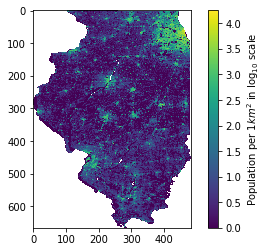

In [41]:
data[data == ds.nodata] = np.nan
data[data == 0] = 0.0001
plt.imshow(np.log10(data), vmin=0)
plt.colorbar(label='Population per 1$km^2$ in $\log_{10}$ scale')

To save the raster image back to file:

In [59]:
target_path = './data/ilpop10.tif'    # replace this with the actual path
with rasterio.open(target_path, 'w', **full_metadata) as ds:    # use the previously copied metadata
    ds.write(data, 1)    # write to the first band

In actual use cases, you may want to edit contents from `full_metadata` accordingly:

In [60]:
full_metadata

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -407649103380480.0,
 'width': 483,
 'height': 666,
 'count': 1,
 'crs': CRS({'init': 'epsg:4326'}),
 'transform': Affine(0.008333333333333345, 0.0, -91.51666666698287,
        0.0, -0.00833333333333333, 42.51666666623275)}

## Reading and writing vector data

One way to think about vector data is that a vector dataset is just a spreadsheet with a column for geolocation (be it point, line, polygon, or multipolygon). This is exactly how vector datasets are represented in GeoPandas.

Here, we will use the following dataset as an example:
> US Census Bureau (2019, February 06). TIGER/Line Shapefile, 2017, nation, U.S., Current County and Equivalent National Shapefile. Retrieved from https://catalog.data.gov/dataset/tiger-line-shapefile-2017-nation-u-s-current-county-and-equivalent-national-shapefile

To open the shapefile:

In [42]:
ds = gpd.read_file('data/tl_2017_us_county.shp')
ds.head()    # get a preview of the first few entries

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477641638,10701538,+41.9158651,-096.7885168,"POLYGON ((-97.019516 42.004097, -97.019519 42...."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680956787,61588406,+46.2946377,-123.4244583,"POLYGON ((-123.436394 46.238197, -123.447592 4..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016761648,29147345,+34.3592729,-104.3686961,"POLYGON ((-104.567387 33.997566, -104.567717 3..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169252486,22867561,+40.7835474,-096.6886584,"POLYGON ((-96.91059899999999 40.958407, -96.91..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645186,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27366699999999 40.089399, -98.27..."


To get some metadata of the dataset:

In [48]:
print('CRS: %s' % str(ds.crs))
print('Columns: %s' % str(list(ds.columns)))
print('Number of entries: %d' % ds.shape[0])

CRS: {'init': 'epsg:4269'}
Columns: ['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry']
Number of entries: 3233


If you want to select, for example, Champaign county of Illinois, whose [GEOID](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html) is 17019, you can do the following:

In [49]:
selection = ds[ds['GEOID'] == '17019']
assert selection.shape[0] == 1    # there should be one and only one Champaign County
champaign_entry = selection.iloc[0]
champaign_entry

STATEFP                                                    17
COUNTYFP                                                  019
COUNTYNS                                             00424211
GEOID                                                   17019
NAME                                                Champaign
NAMELSAD                                     Champaign County
LSAD                                                       06
CLASSFP                                                    H1
MTFCC                                                   G4020
CSAFP                                                    None
CBSAFP                                                  16580
METDIVFP                                                 None
FUNCSTAT                                                    A
ALAND                                              2579733580
AWATER                                                6091992
INTPTLAT                                          +40.1389800
INTPTLON

You can obtain its geometry—in this case, it is a polygon—from the "geometry" field:

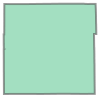

In [52]:
champaign_entry['geometry']    # Jupyter is capable of visualizing polygons automatically

You can apply a number of geometric operations on this shape (which is implemented as a Shapely geometry, so you can find more details reading Shapely documentation). For example:

In [74]:
print('Area: %.2f' % champaign_entry['geometry'].area)
print('Centroid: %s' % str(champaign_entry['geometry'].centroid))
print('The centroid of the polygon is within the polygon:',
          champaign_entry['geometry'].centroid.within(champaign_entry['geometry']))
print('Equivalently, the polygon contains the centroid of itself:',
          champaign_entry['geometry'].contains(champaign_entry['geometry'].centroid))
print('The polygon is essentially an ordered list of points. The first point is:',
          champaign_entry['geometry'].exterior.coords[0])

Area: 0.27
Centroid: POINT (-88.19919185164987 40.14008385022409)
The centroid of the polygon is within the polygon: True
Equivalently, the polygon contains the centroid of itself: True
The polygon is essentially an ordered list of points. The first point is: (-88.463174, 40.142196)


To save a vector GeoDataFrame to file, simply do the following:

In [55]:
target_path = './data/tl_2017_us_county.shp'    # replace this with the actual path
ds.to_file(target_path)

/anaconda3/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


The syntax of GeoPandas is almost identical to that of Pandas. If you are not familiar with Pandas, please refer to the [10 Minutes to Pandas tutorial](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html).

**Note on GeoPackage**: one of the few advantages of ESRI Shapefile over GeoPackage is that ESRI allows the entries to have different geometry types—GeoPackage doesn't. For example, in this datasets, most counties are polygon, but some of them are multipolygon (a group of polygons), as some counties next to lakes or oceans may have islands in them. If you want to save it as `.gpkg` file, you will have to either drop the smaller parts of each county, or convert all polygons to multipolygons.

## Data interoperability
### Reprojection

### Clipping

## Visualization
### Visualization with QGIS

### Visualization with GeoPandas

### Visualization with Matplotlib
You may find the [Basemap](https://matplotlib.org/basemap/) tookit of Matplotlib useful if you want to stick with Matplotlib.

## Examples
### Generating US state-level precipitation map